<a href="https://colab.research.google.com/github/pibicagrofinance/Jupyter_Notebooks/blob/main/Commodities_prices_and_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 style="text-align: center;"><em>Impact of Sentiment Analysis on the Volatility and Structural Breaks in Agricultural Commodity Prices</em></h1>

<p style="text-align: center;"><strong>Authors:</strong> Rodrigo Hermont Ozon, Ricardo Vianna, Gabrielly dos Santos Matheus Souza</p>







## Project Overview

In this notebook, we'll:

- Install and import necessary libraries.

- Define assets and their corresponding keywords for Google Trends.

- Collect price data for the assets.

- Collect Google Trends data for the keywords.

- Merge and align the time series data.

- Identify peaks and valleys in the price and trend data.

- Fetch news articles around the dates of identified events.

- Filter and analyze the news using a Large Language Model (LLM).

- Associate the news with the events and perform statistical analysis.

- Visualize the results.


### Python libs



In [ ]:

# Install necessary libraries
!pip install yfinance
!pip install pytrends
!pip install plotly
!pip install transformers
!pip install sentencepiece
!pip install torch


In [ ]:

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import time
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import specific modules
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError, ResponseError
from datetime import timedelta
from scipy.signal import find_peaks
from transformers import pipeline

# Ensure that plots are displayed correctly in Colab
%matplotlib inline


In [ ]:

# Define assets and their corresponding keywords
assets_keywords = {
    "corn_fut": ["corn price", "corn futures", "maize market"],
    "wheat_fut": ["wheat price", "wheat futures", "wheat market"],
    "KCWheat_fut": ["hard red wheat", "kansas wheat", "hrw wheat"],
    "rice_fut": ["rice price", "rice futures", "rice market"],
    "Feeder_Cattle": ["cattle prices", "beef market", "livestock prices"],
    "soymeal_fut": ["soybean meal price", "soymeal futures", "soybean meal market"],
    "soyoil_fut": ["soybean oil price", "soyoil futures", "soybean oil market"],
    "soybeans_fut": ["soybean price", "soybean futures", "soybean market"]
}


In [ ]:

# Map asset names to Yahoo Finance tickers
ticker_mapping = {
    "corn_fut": "ZC=F",
    "wheat_fut": "ZW=F",        # Correct ticker for Wheat Futures
    "KCWheat_fut": "KE=F",
    "rice_fut": "ZR=F",
    "Feeder_Cattle": "GF=F",
    "soymeal_fut": "ZM=F",      # Soybean Meal Futures
    "soyoil_fut": "ZL=F",       # Soybean Oil Futures
    "soybeans_fut": "ZS=F"      # Soybean Futures
}

# Download price data
price_data = yf.download(
    tickers=list(ticker_mapping.values()),
    start="2019-01-01",
    end="2023-12-31"
)

# Check if 'Adj Close' is in the downloaded data
if 'Adj Close' in price_data.columns.levels[0]:
    # Use the 'Adj Close' prices
    price_data = price_data['Adj Close']
else:
    # Use the 'Close' prices as a fallback
    price_data = price_data['Close']

# Rename columns based on asset names
price_data.columns = list(ticker_mapping.keys())

# Drop rows with missing values
price_data.dropna(inplace=True)

# Reset index to make 'Date' a column
price_data.reset_index(inplace=True)

# Display the first few rows of price data
print("Price Data:")
display(price_data.head())


[*********************100%***********************]  8 of 8 completed

Price Data:


,Date,corn_fut,wheat_fut,KCWheat_fut,rice_fut,Feeder_Cattle,soymeal_fut,soyoil_fut,soybeans_fut
0,2019-01-02 00:00:00+00:00,147.949997,492.5,375.75,27.90,311.000000,1008.5,894.75,506.75
1,2019-01-03 00:00:00+00:00,146.524994,503.5,379.75,28.18,312.700012,1017.0,900.25,513.75
2,2019-01-04 00:00:00+00:00,144.899994,506.0,383.00,28.41,315.100006,1022.5,909.50,517.00
3,2019-01-07 00:00:00+00:00,146.000000,503.0,382.25,28.26,318.200012,1040.5,912.25,516.75
4,2019-01-08 00:00:00+00:00,147.625000,505.0,380.00,28.18,317.600006,1049.0,906.25,517.75


In [ ]:

# Initialize PyTrends with a custom User-Agent
pytrends = TrendReq(
    hl='en-US',
    tz=360,
    requests_args={'headers': {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                      'AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/88.0.4324.96 Safari/537.36'
    }}
)

# Define the timeframe
timeframe = '2019-01-01 2023-12-31'

# DataFrame to store all trends
all_trends = pd.DataFrame()

# Delete the existing CSV file to ensure fresh data
if os.path.exists('google_trends_data.csv'):
    os.remove('google_trends_data.csv')
    print("Old 'google_trends_data.csv' file deleted.")

# Collect trends data for each asset
for asset, keywords in assets_keywords.items():
    success = False
    retries = 0
    max_retries = 5  # Set a maximum number of retries

    while not success and retries < max_retries:
        try:
            # Build the payload
            pytrends.build_payload(keywords, timeframe=timeframe)
            # Fetch interest over time
            data_trends = pytrends.interest_over_time()

            # Check if data is returned
            if data_trends.empty:
                print(f"No data returned for {asset}. Skipping to next asset.")
                break

            # Remove 'isPartial' column if it exists
            if 'isPartial' in data_trends.columns:
                data_trends = data_trends.drop(columns=['isPartial'])

            # Calculate the mean trend across keywords
            data_trends[asset + '_trend'] = data_trends.mean(axis=1)

            # Keep only the mean trend column
            data_trends = data_trends[[asset + '_trend']]

            # Merge with the main trends DataFrame
            if all_trends.empty:
                all_trends = data_trends
            else:
                all_trends = all_trends.join(data_trends, how='outer')

            success = True  # Exit the loop if successful

            # Add a delay to prevent hitting the rate limit
            time.sleep(5)  # Wait for 5 seconds before the next request

        except (TooManyRequestsError, ResponseError) as e:
            retries += 1
            wait_time = 60 * retries  # Exponential backoff
            print(f"Error '{e}' when processing {asset}. Waiting {wait_time} seconds before retrying...")
            time.sleep(wait_time)  # Wait before retrying
        except Exception as e:
            print(f"An unexpected error occurred while processing {asset}: {e}")
            break  # Break the loop if other errors occur

    if not success:
        print(f"Failed to retrieve data for {asset} after {max_retries} retries.")
        continue  # Skip to the next asset

# Set the index name to 'date' before resetting
all_trends.index.name = 'date'

# Reset the index to turn 'date' into a column
all_trends.reset_index(inplace=True)

# Verify that 'date' is now a column in all_trends
print("Columns in all_trends before saving:", all_trends.columns.tolist())

# Save the data to a CSV file
all_trends.to_csv('google_trends_data.csv', index=False)
print("Google Trends data saved to 'google_trends_data.csv'.")

# Display the first few rows
print("Google Trends Data:")
display(all_trends.head())


Old 'google_trends_data.csv' file deleted.
Columns in all_trends before saving: ['date', 'corn_fut_trend', 'wheat_fut_trend', 'KCWheat_fut_trend', 'rice_fut_trend', 'Feeder_Cattle_trend', 'soymeal_fut_trend', 'soyoil_fut_trend', 'soybeans_fut_trend']
Google Trends data saved to 'google_trends_data.csv'.
Google Trends Data:


,date,corn_fut_trend,wheat_fut_trend,KCWheat_fut_trend,rice_fut_trend,Feeder_Cattle_trend,soymeal_fut_trend,soyoil_fut_trend,soybeans_fut_trend
0,2018-12-30,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
1,2019-01-06,14.333333,6.666667,25.333333,15.0,35.666667,0.0,2.000000,12.000000
2,2019-01-13,14.000000,7.000000,26.333333,15.0,33.666667,0.0,1.666667,10.666667
3,2019-01-20,15.666667,6.666667,19.333333,15.0,35.666667,0.0,2.333333,10.666667
4,2019-01-27,15.666667,7.666667,22.333333,15.0,32.000000,0.0,2.333333,11.333333


In [ ]:

# Load data from CSV and parse dates
all_trends = pd.read_csv('google_trends_data.csv', parse_dates=['date'])
print("Google Trends data loaded from 'google_trends_data.csv'.")

# Display the first few rows
print("Google Trends Data:")
display(all_trends.head())


Google Trends data loaded from 'google_trends_data.csv'.
Google Trends Data:


,date,corn_fut_trend,wheat_fut_trend,KCWheat_fut_trend,rice_fut_trend,Feeder_Cattle_trend,soymeal_fut_trend,soyoil_fut_trend,soybeans_fut_trend
0,2018-12-30,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
1,2019-01-06,14.333333,6.666667,25.333333,15.0,35.666667,0.0,2.000000,12.000000
2,2019-01-13,14.000000,7.000000,26.333333,15.0,33.666667,0.0,1.666667,10.666667
3,2019-01-20,15.666667,6.666667,19.333333,15.0,35.666667,0.0,2.333333,10.666667
4,2019-01-27,15.666667,7.666667,22.333333,15.0,32.000000,0.0,2.333333,11.333333


In [ ]:

# Merge data using 'outer' join to keep all dates from both datasets
merged_data_outer = pd.merge(price_data, all_trends, left_on='Date', right_on='date', how='outer')

# Remove the duplicate 'date' column
merged_data_outer.drop(columns=['date'], inplace=True)

# Display the number of rows and check for missing values
print(f"Number of rows in merged_data (outer merge): {len(merged_data_outer)}")

# Check for missing values in the merged data
missing_values_outer = merged_data_outer.isnull().sum()
print("\nMissing values in each column (outer merge):")
print(missing_values_outer)


ValueError: You are trying to merge on datetime64[ns, UTC] and datetime64[ns] columns for key 'Date'. If you wish to proceed you should use pd.concat

In [ ]:

# Fill missing values with forward fill
merged_data_outer.fillna(method='ffill', inplace=True)

# Optionally: If forward fill doesn't fill all, apply backward fill for remaining NaNs
merged_data_outer.fillna(method='bfill', inplace=True)

# Display the first few rows after filling missing values
print("Data after filling missing values:")
display(merged_data_outer.head())


Data after filling missing values:


,Date,corn_fut,wheat_fut,KCWheat_fut,rice_fut,Feeder_Cattle,soymeal_fut,soyoil_fut,soybeans_fut,corn_fut_trend,wheat_fut_trend,KCWheat_fut_trend,rice_fut_trend,Feeder_Cattle_trend,soymeal_fut_trend,soyoil_fut_trend,soybeans_fut_trend
0,2019-01-02 00:00:00+00:00,147.949997,492.5,375.75,27.90,311.000000,1008.5,894.75,506.75,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
1,2019-01-03 00:00:00+00:00,146.524994,503.5,379.75,28.18,312.700012,1017.0,900.25,513.75,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
2,2019-01-04 00:00:00+00:00,144.899994,506.0,383.00,28.41,315.100006,1022.5,909.50,517.00,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
3,2019-01-07 00:00:00+00:00,146.000000,503.0,382.25,28.26,318.200012,1040.5,912.25,516.75,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333
4,2019-01-08 00:00:00+00:00,147.625000,505.0,380.00,28.18,317.600006,1049.0,906.25,517.75,14.333333,5.666667,18.666667,15.0,35.666667,0.0,1.666667,10.333333


In [ ]:

# Dictionaries to store peak and valley dates
peaks_dates = {}
valleys_dates = {}

for asset in assets_keywords.keys():
    # Price series for each asset
    price_series = merged_data_outer[asset].values

    # Identify peaks in prices
    peaks, _ = find_peaks(price_series, prominence=1)
    peaks_dates[asset] = merged_data_outer['Date'].iloc[peaks]

    # Identify valleys in prices (inverting the series)
    valleys, _ = find_peaks(-price_series, prominence=1)
    valleys_dates[asset] = merged_data_outer['Date'].iloc[valleys]

# Check the peaks and valleys for other assets like wheat, rice, etc.
print(f"Peaks in wheat_fut prices:\n{peaks_dates['wheat_fut'].head()}")
print(f"Valleys in rice_fut prices:\n{valleys_dates['rice_fut'].head()}")


Peaks in wheat_fut prices:
2    2019-01-04 00:00:00+00:00
5    2019-01-09 00:00:00+00:00
7    2019-01-11 00:00:00+00:00
14   2019-01-23 00:00:00+00:00
19   2019-01-30 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]
Valleys in rice_fut prices:
88    2019-05-09 00:00:00+00:00
127   2019-07-05 00:00:00+00:00
164   2019-08-27 00:00:00+00:00
186   2019-09-27 00:00:00+00:00
231   2019-12-02 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


In [ ]:

import requests

# Your ContextualWeb API key
api_key = "YOUR_API_KEY"  # Replace with your actual API key

# Function to fetch news for a specific query
def fetch_contextualweb_news(query, from_date, to_date):
    url = f"https://contextualwebsearch-websearch-v1.p.rapidapi.com/api/search/NewsSearchAPI"
    headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "contextualwebsearch-websearch-v1.p.rapidapi.com"
    }
    params = {
        "q": query,
        "pageNumber": "1",
        "pageSize": "10",  # Adjust as needed
        "fromPublishedDate": from_date,
        "toPublishedDate": to_date
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json()

# Example query
query = "corn"
from_date = "2019-01-01"
to_date = "2019-01-10"

# Fetch news articles
news_data = fetch_contextualweb_news(query, from_date, to_date)

# Print the news results
print("ContextualWeb News API Response:")
print(news_data)


Query: corn price | Date Range: 2019-01-05 to 2019-01-11
No news found for corn_fut between 2019-01-05 and 2019-01-11.
Query: wheat price | Date Range: 2019-01-01 to 2019-01-07
No news found for wheat_fut between 2019-01-01 and 2019-01-07.
Query: hard red wheat | Date Range: 2019-01-01 to 2019-01-07
No news found for KCWheat_fut between 2019-01-01 and 2019-01-07.
Query: rice price | Date Range: 2019-02-03 to 2019-02-09
No news found for rice_fut between 2019-02-03 and 2019-02-09.
Query: cattle prices | Date Range: 2019-01-06 to 2019-01-12
No news found for Feeder_Cattle between 2019-01-06 and 2019-01-12.
Query: soybean meal price | Date Range: 2019-01-07 to 2019-01-13
No news found for soymeal_fut between 2019-01-07 and 2019-01-13.
Query: soybean oil price | Date Range: 2019-01-04 to 2019-01-10
No news found for soyoil_fut between 2019-01-04 and 2019-01-10.
Query: soybean price | Date Range: 2019-01-06 to 2019-01-12
No news found for soybeans_fut between 2019-01-06 and 2019-01-12.
Fetc

""


Fetched News Data:


""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

KeyError: 'description'

Google Trends Data for Commodities:
        date  corn  wheat  soybeans  rice  cattle
0 2018-12-30    37     63        59    61      51
1 2019-01-06    36     75        80    63      59
2 2019-01-13    36     70        63    62      57
3 2019-01-20    35     68        59    66      58
4 2019-01-27    36     64        83    61      59


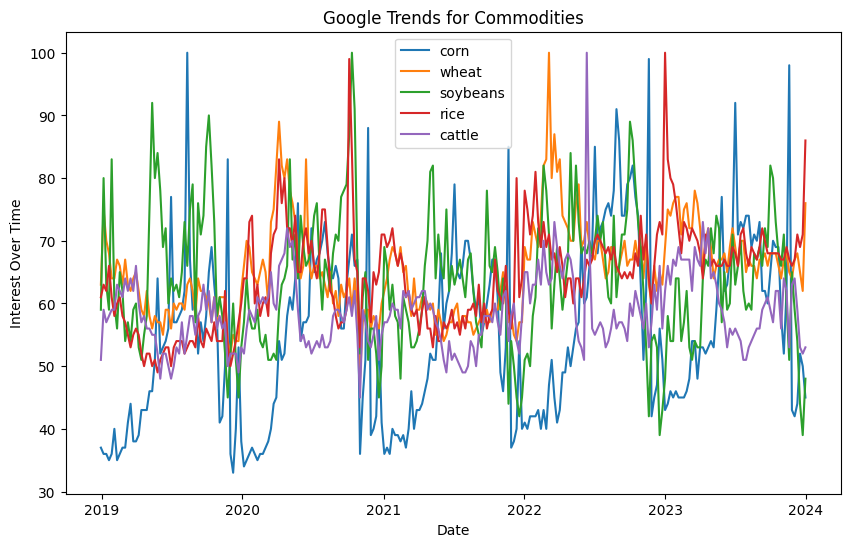

FileNotFoundError: [Errno 2] No such file or directory: 'your_price_data.csv'

In [ ]:

# Import necessary libraries
from pytrends.request import TrendReq
import pandas as pd
import time
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Set up Google Trends
pytrends = TrendReq(hl='en-US', tz=360)

# Define the keywords for the commodities in your portfolio
kw_list = ['corn', 'wheat', 'soybeans', 'rice', 'cattle']

# Fetch trends data for each commodity
trends_data = pd.DataFrame()

for kw in kw_list:
    # Build the payload
    pytrends.build_payload([kw], timeframe='2019-01-01 2023-12-31', geo='US')

    # Get interest over time
    data = pytrends.interest_over_time()

    if not data.empty:
        # Only keep the interest data, drop 'isPartial' column if exists
        data = data.drop(columns=['isPartial'], errors='ignore')
        trends_data = pd.concat([trends_data, data], axis=1)

    # Delay between requests to avoid getting rate-limited by Google
    time.sleep(5)

# Reset the index to make 'date' a column if necessary
trends_data.reset_index(inplace=True)

# Display the fetched Google Trends data
print("Google Trends Data for Commodities:")
print(trends_data.head())

# Plot the trends data
plt.figure(figsize=(10,6))
for kw in kw_list:
    plt.plot(trends_data['date'], trends_data[kw], label=kw)
plt.title("Google Trends for Commodities")
plt.xlabel("Date")
plt.ylabel("Interest Over Time")
plt.legend()
plt.show()

# Load your actual commodity price data
# Replace this example with your real price data
# Assuming you have columns: 'date', 'corn_price', 'wheat_price', 'soybeans_price', 'rice_price', 'cattle_price'
price_data = pd.read_csv('your_price_data.csv')  # Load your actual price data from CSV

# Merge Google Trends data with price data
merged_data = pd.merge(trends_data, price_data, on='date')

# Display the merged data
print("Merged Trends and Price Data:")
print(merged_data.head())

# Calculate correlation between Google Trends and commodity prices
correlation = merged_data.corr()
print("Correlation between Google Trends and Prices:")
print(correlation)

# Example of analyzing peaks and valleys for 'corn' trends
corn_trends = merged_data['corn'].values
peaks, _ = find_peaks(corn_trends, prominence=1)
valleys, _ = find_peaks(-corn_trends, prominence=1)

# Print the dates of peaks and valleys in corn trends
print("Peaks in corn trends at dates:")
print(merged_data['date'].iloc[peaks])

print("Valleys in corn trends at dates:")
print(merged_data['date'].iloc[valleys])

# Plot the peaks and valleys for corn trends
plt.figure(figsize=(10,6))
plt.plot(merged_data['date'], merged_data['corn'], label='Corn Trends')
plt.plot(merged_data['date'].iloc[peaks], corn_trends[peaks], "x", label='Peaks', color='green')
plt.plot(merged_data['date'].iloc[valleys], corn_trends[valleys], "o", label='Valleys', color='red')
plt.title("Corn Trends with Peaks and Valleys")
plt.xlabel("Date")
plt.ylabel("Interest Over Time")
plt.legend()
plt.show()

# Repeat the process for other commodities if needed

